In [1]:
import copy
import tensorflow as tf

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## -- EMBEDDING NETWORKS --- ##
def get_embedding_network(shape):
    inputs = tf.keras.layers.Input(shape)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Flatten layer / Global Max Pooling
    # x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    encoder = tf.keras.Model(inputs, x, name="embedding")
    # encoder.summary()
    return encoder

In [3]:
def get_triplet_siamese_net(img_shape):
    encoder = get_embedding_network(img_shape)

    anchor_input = tf.keras.layers.Input(name="anchor", shape=img_shape)
    positive_input = tf.keras.layers.Input(name="positive", shape=img_shape)
    negative_input = tf.keras.layers.Input(name="negative", shape=img_shape)

    anchor_encoded = encoder(anchor_input)
    positive_encoded = encoder(positive_input)
    negative_encoded = encoder(negative_input)

    # Distance layer
    dist_layer = tf.keras.layers.Lambda(triplet_pairs_distance, name = 'distance_layer')  
    
    # Output layer
    distances = dist_layer([anchor_encoded, positive_encoded, negative_encoded])

    # Connect the inputs with the outputs
    model = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)
    return model

In [4]:
# triplet ap_distance, an_distance
def triplet_pairs_distance(vectors):
    (anchor, positive, negative) = vectors
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap_distance, an_distance)

### le 2 funzioni di get siamese net, get embedding sono diverse. triplet_pairs_distance non ce l'ho nella 2SNN

In [5]:
import os
import cv2
import copy
import random
import numpy as np

# get k random element from a list 
def get_n_rnd_element_from_list(lst, n):
#     return random.choices(lst, k=n)
    return random.sample(lst, k=n)

# get k random element from a list excluding the exception parameter value from the list
def get_n_rnd_element_from_list_excluding_parameter(lst, exception, n):
    possible_choices = [v for v in lst if v != exception]
    return get_n_rnd_element_from_list(possible_choices, n)

def add_channel_dimension(img):
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    return img[..., tf.newaxis]


#### VARIANTE ####
def read_image(path, img_type):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB if img_type == 'RGB' else cv2.COLOR_BGR2GRAY)

In [6]:
src = 'images'
val_classes = ['162.Canada_Warbler', '050.Eared_Grebe', '140.Summer_Tanager', '195.Carolina_Wren', '176.Prairie_Warbler']
test_classes = ['057.Rose_breasted_Grosbeak', '047.American_Goldfinch', '094.White_breasted_Nuthatch', '143.Caspian_Tern', '038.Great_Crested_Flycatcher']

In [7]:
sh = (224, 224, 3)

In [8]:
model = get_triplet_siamese_net(sh)

Metal device set to: Apple M1


2023-03-27 16:46:36.677396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 16:46:36.677835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model.load_weights('siamese_net.h5')

Val/test accuracy performance

In [10]:
def one_shot_validate_triplet(model, classes, C, src, runs_per_class, img_type):
    print('Making ' + str(runs_per_class) + ' random tasks (per class) on ' + str(C) + '-Way One-Shot support sets...')
    mean_global_accuracy = 0

    for cla in classes:
        mean_class_accuracy = 0

        for _ in range(runs_per_class):
            anchor_img, positive_img, negatives, labels = get_one_shot_batch_validate_triplet(cla, classes, C, src, img_type)

            distances = []
            for i in range(len(negatives)):
                X = [[anchor_img, positive_img, negatives[i]]]
                X = np.array(X)
                ap_distance, an_distance = model([X[:,0], X[:,1], X[:,2]])

                if i == 0:
                    distances.append(ap_distance.numpy()[0]) # ap_distance la salvo come prima e soltanto una volta

                distances.append(an_distance.numpy()[0])

            if np.argmin(distances) == 0: # the smallest distance must be the first one (anchor-positive pair)
                accuracy = 1.0
            else:
                accuracy = 0.0

            mean_class_accuracy += accuracy
            mean_global_accuracy += accuracy

        mean_class_accuracy /= runs_per_class
        print(cla + ' Class' + ', accuracy: ' + str(mean_class_accuracy))

    mean_global_accuracy /= (len(classes) * runs_per_class)
    print('Mean global accuracy: ' + str(mean_global_accuracy))
    print('----------------------------------------------------------------')
    
    return mean_global_accuracy

In [11]:
def get_one_shot_batch_validate_triplet(anchor_class, classes, C, src, img_type):
    negatives, labels = [], []
    
    anchor_samples = get_n_rnd_element_from_list(os.listdir(os.path.join(src, anchor_class)), 2) # select anchor, positive
    
    # anchor, positive samplese
    anchor_sample, positive_sample = anchor_samples[0], anchor_samples[1]
    anchor_img = read_image(os.path.join(src, anchor_class, anchor_sample), img_type) 
    positive_img = read_image(os.path.join(src, anchor_class, positive_sample), img_type) 

    labels.append(anchor_class)

    # negative pair samples
    negative_classes = get_n_rnd_element_from_list_excluding_parameter(classes, anchor_class, C - 1) # get all classes different from the query class
    for neg_class in negative_classes:
        neg_sample = get_n_rnd_element_from_list(os.listdir(os.path.join(src, neg_class)), 1)[0] # select a random sample of the current class
        neg_img = read_image(os.path.join(src, neg_class, neg_sample), img_type) 
        
        negatives.append(neg_img)
        labels.append(neg_class)
        
    return anchor_img, positive_img, negatives, labels

In [12]:
# print("Validate on evaluation alphabets...")
# one_shot_validate_triplet(model, val_classes, len(val_classes), src, 300, 'RGB')
# print("Validate on test alphabets...")
# one_shot_validate_triplet(model, test_classes, len(test_classes), src, 300, 'RGB')

In [13]:
# def get_train_batch_triplet(src, classes, n_pairs, img_type, batch_size):
#     X, labels = [], []

#     while(len(X) < batch_size):
#         query_class = get_k_rnd_element_from_list(classes, 1)[0]
#         query_samples = get_k_rnd_element_from_list(os.listdir(os.path.join(src, query_class)), 2) # select anchor, positive
        
#         # anchor, positive samplese
#         anchor_sample, positive_sample = query_samples[0], query_samples[1]
#         anchor_img = read_image(os.path.join(src, query_class, anchor_sample), img_type) 
#         positive_img = read_image(os.path.join(src, query_class, positive_sample), img_type) 

#         # negeative sample
#         negative_class = get_k_rnd_element_from_list_excluding_parameter(classes, query_class, 1)[0] # get one random class different from the query class
#         neg_sample = get_k_rnd_element_from_list(os.listdir(os.path.join(src, negative_class)), 1)[0] # select negative sample
#         negative_img = read_image(os.path.join(src, negative_class, neg_sample), img_type) 

#         X.append([anchor_img, positive_img, negative_img])
#         labels.append([query_class, query_class, negative_class])

#     y = np.ones(len(X))
#     return np.array(X), np.array(y), labels

In [14]:
def expand_dimension(s):
    ''' Expand the spectrogram dimensions for tensorflow predict_on_batch function use 
        input s: spectrogram '''
    return np.expand_dims(copy.deepcopy(s), axis=0)

# modifica al predict similarity qui sopra. non mi interessa avere distanza tr apositivi e negativi perchè 
## l'embedder che vado ad interrogare è poi sempre lo stesso. faccio in modo da resituire sempre
### ap_distance e passare a questa func parametri in modo tale da volere la similarity tra loro due 
def predict_similarity(f, anchor, s):
    X = np.array([[anchor, s, s]])
    ap_dist, _ = model([X[:,0], X[:,1], X[:,2]])
    return ap_dist.numpy()[0]
#     return ap_dist.numpy()[0] if distance_with_positive_sample == True else an_dist.numpy()[0]

In [15]:
from skimage import morphology
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, find_boundaries

In [16]:
def preprocess_img(img):
    ni = None
    
    if len(img.shape) == 2:
        # Two dimensions found. Adding fake channel and stacking it in each RGB dimension.
        ni = add_channel_dimension(img)
        ni = stack_image(ni)
    elif img.shape[2] != 3:
        # Third dimension does not have 3 channels. Stacking the first one in each RGB dimension.
        ni = stack_image(img)
    
    return ni

In [17]:
# IDENTICO STATO ATTUALE GITHUB
from matplotlib.colors import LinearSegmentedColormap

shapelike_cmap = LinearSegmentedColormap.from_list('shaplike_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#1E88E5-91C5F2-FFFFFF-FF6395-FF0052
    (0.000, (0.118, 0.533, 0.898)),
    (0.250, (0.569, 0.773, 0.949)),
    (0.500, (1.000, 1.000, 1.000)),
    (0.750, (1.000, 0.388, 0.584)),
    (1.000, (1.000, 0.000, 0.322)))
)

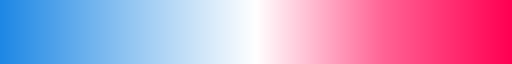

In [19]:
shapelike_cmap

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})

In [19]:
def plot_explanation_omniglet(x, S, labels, norm_attributions, probabilities, cmap):
    N = len(norm_attributions)
    
    plt.figure()
    f, axarr = plt.subplots(3, N + 1,figsize=(30,20))

    axarr[1, 0].imshow(x)
    axarr[1, 0].set_axis_off()
    axarr[1, 0].set_title('Query x;\n y = ' + str(labels[0]))

    for i in range(N):
        sim = round(probabilities[i], 3)
    
        # THIRD ROW: Normalized attributions
#         im3 = axarr[0, i+1].imshow(norm_attributions[i], cmap='coolwarm', interpolation='none', vmin=-1, vmax=1)
        im3 = axarr[0, i+1].imshow(np.sum(norm_attributions[i], axis=-1), cmap='coolwarm_r', interpolation='none', vmin=-1, vmax=1)
        #         plt.colorbar(im3, ax=axarr[0, i+1])
        axarr[0, i+1].set_axis_off()
        
        
        # 4th ROW: Original Inputs
        axarr[1, i+1].imshow(S[i])
        axarr[1, i+1].set_axis_off()
        subscripts = 's' + str(i+1)
        axarr[1, i+1].set_title(subscripts + "; dist = " + str(sim))
        
        # 5th row: overlap
        axarr[2, i+1].imshow(S[i], alpha=0.7)
        axarr[2, i+1].imshow(np.sum(norm_attributions[i], axis=-1), cmap='coolwarm_r', interpolation='none', vmin=-1, vmax=1, alpha=0.7)
        axarr[2, i+1].set_axis_off()

    # Empty 2 row 1 column element
    axarr[0, 0].set_axis_off()
    axarr[0, 0].text(0.0, 0.5, '')
    axarr[2, 0].set_axis_off()
    axarr[2, 0].text(0.0, 0.5, '')
    
    
    f.subplots_adjust(right=0.95)  # making some room for cbar
    # getting the lower left (x0,y0) and upper right (x1,y1) corners:
    [[x00,y00],[x01,y01]] = axarr[0, N].get_position().get_points()
    [[x10,y10],[x11,y11]] = axarr[1, N].get_position().get_points()
    
    pad = 0.01; width = 0.005
    cbar_ax = f.add_axes([x11+pad, y10, width, y01-y10])
    axcb = f.colorbar(im3, cax=cbar_ax)
    # axcb = f.colorbar(im3, cax=cbar_ax, ticks=[-1, 0, 1])
    # axcb.ax.set_yticklabels([str(max_neg), '0', str(max_pos)])  # vertically oriented colorbar
    
    plt.show()

In [20]:
stack_required = 0 # da inserire in qualche parte in sinex quando si inizializza, dipende dal dataset

In [21]:
def segment_input(img_to_segment):
    if stack_required:
        img_to_segment = preprocess_img(img_to_segment)
        
    if sobel_required: # Watershed
        img_to_segment = sobel(rgb2gray(img_to_segment))
        
    if mask_required: # MaskSLIC
        ar = morphology.remove_small_objects(ar = rgb2gray(img_to_segment) < 0.5, min_size = 200)
        mask = morphology.remove_small_holes(ar = ar, area_threshold = 500)
        mask = morphology.opening(mask)
        aparams['mask'] = mask

    R = algo(image=img_to_segment, **aparams) # creating segments on support set si input
#     nR = np.unique(R).shape[0] # number of segments
    uR = np.unique(R) # unique segments
    
    return R, uR 

In [22]:
# METODO DIVERSO RISPETTO LO STATO ATTUALE DI SINEX, bisogna vedere se si può uniformare allo stato attuale di sinex
def perturb_image_by_disabling(img, segments, segments_to_disable, replace_value = 0):
    wc = copy.deepcopy(img) # makes a working deep copy of the image 

    for seg in segments_to_disable:
        pixels = np.where(segments==seg) # finding segment's pixel coordinate
        wc[pixels] = replace_value # replacing value
    
    return wc # sto restituendo solo l'ultimo pixels: WARNING! al momento questo metovo viene usato
    # passando solo 1 segmento come parametro
    
  #  return wc, np.where(wc == replace_value)

qui è diverso da quello vecchio, ho aggiunto l'original_img come parametro da cui prendere i valori della vecchia

In [23]:
def perturb_image_by_enabling(empty_img, segments, segments_to_enable, original_image):
    wc = copy.deepcopy(empty_img) # makes a working deep copy of the image 
    
    for seg in segments_to_enable:
        pixels = np.where(segments==seg) # finding segment's pixel coordinate
        wc[pixels] = original_image[pixels] # replacing value

    # return wc, pixels
    return wc

# SINEX

In [24]:
REPLACE_SEG_VALUE = 128

In [25]:
def explain_sinex(f, x, S, verbose=False):
    E = []
    C = {} # { sidx: {'segments': [...], 'deltas': []} } contribution values map
    
    for sidx in range(len(S)):
        si = S[sidx] # support set si
        v = predict_similarity(f, x, si)
        
        if verbose:
            print("Analyzig support set index:", sidx, "Predicted distance:", v)

        R, uR = segment_input(si.copy()) # creating segments on support set si input
#         print("len segments", len(uR))

        
        # Initializes current sample contribution
        hi = np.full(sh, float("-inf"))
        
        if verbose:
            plt.imshow(si)
            plt.axis('off')
            plt.show()
            
            seg_input = mark_boundaries(si, R, mode='thick')
            plt.imshow(seg_input) # modifica rispetto al sinex omniglet
            plt.axis('off')
            plt.show()
        
        C[sidx] = {} # segment -> delta map init
        C[sidx]['R'], C[sidx]['contr_seg_map'] = R, []
        
        
        if mask_required == 1:
            # REMOVAL FORZATO PER MASKSLIC segmnento 0 è la maschera (o la somma di tutti i segm)
            uR = np.delete(uR, np.where(uR == 0))

        for seg in uR:
            if mode == 1:
                zi = perturb_image_by_enabling(np.full(sh, REPLACE_SEG_VALUE), R, [seg], si)
            else:
                # disabilitare solo current seg 
                zi = perturb_image_by_disabling(si, R, [seg], [REPLACE_SEG_VALUE,REPLACE_SEG_VALUE,REPLACE_SEG_VALUE])
            
            idxs = np.where(R == seg)
            pxl = si[idxs]
            
                
            u = predict_similarity(f, x, zi) # calculate new similarity
            d = v - u # calculate delta of similarity scores
            c = d / len(pxl) 
            hi[idxs] = c
            



            
            if verbose:
                print("New dist:", u)
                print("Delta:", d)
                print("Contribution:", c)
                print("Segment:", seg)
                print("Len:", len(pxl))
                plt.imshow(zi)
                plt.axis('off')
                plt.show()
                
                
                newR = np.full((224,224), 0)
                indexes_newR = np.where(R == seg)
                newR[indexes_newR] = R[indexes_newR]
                seg_input = mark_boundaries(si, newR, mode='thick')
                plt.imshow(seg_input)
                plt.axis('off')
                plt.show()
                
                print("-------------------")

            # append contribution value of the current segment 
            C[sidx]['contr_seg_map'].append((c, seg))
                
        # Appending current support set attribution's vector
        E.append(hi)
    
    return E, C

# SINEXC

In [26]:
def get_segments_to_disable_sinexc(curr_seg, drawn_segments):
    drawn = drawn_segments.copy()
    
    if mask_required == 1:
         # REMOVAL FORZATO PER MASKSLIC -> seg 0 è la maschera (o la somma di tutit i sgem)
        drawn.remove(0)
    
    
    total_segs_to_disable = round((len(drawn) * percentage_of_segments_to_disable) / 100)
    
#     print("Total sample to disable", total_segs_to_disable)
#     print("Total drawn segments", drawn)
    
    if total_segs_to_disable <= 1:
#         lo forzo ad averne 2, in modo tale da sceglierne poi solo 1 oltre il curr seg
        total_segs_to_disable = 2
    
    random_sample = random.sample(drawn, total_segs_to_disable - 1)
    random_sample.append(curr_seg)
    
    return random_sample

In [27]:
def explain_sinexc(f, x, S, verbose=False):
    E = []
    C = {}
    
    for sidx in range(len(S)):
        si = S[sidx] # support set si

        v = predict_similarity(f, x, si) # calculate initial similarity
        
        if verbose:
            print("Analyzig support set index:", sidx, "Predicted distance:", v)

        R, uR = segment_input(si.copy()) # creating segments on support set si input

        # Initializes current sample contribution
        hi = np.full(sh, float("-inf"))
        
        if verbose:
            seg_input = mark_boundaries(si, R)
            plt.imshow(seg_input) # modifica rispetto al sinex omniglet
            plt.show()
        
        C[sidx] = {} # segment -> delta map init
        C[sidx]['R'], C[sidx]['contr_seg_map'] = R, []
        
        if mask_required == 1:
            # REMOVAL FORZATO PER MASKSLIC segmnento 0 è la maschera (o la somma di tutti i segm)
            uR = np.delete(uR, np.where(uR == 0))

        for seg in uR:
            sims = 0

            if verbose:
                print("Segment in analysis:", seg)

            for p in range(P):
                segs_to_disable = get_segments_to_disable_sinexc(seg, list(uR))

                if mode == 1: # curr seg deve rimanere attivo insieme ad un tot di altri
                    segs_to_enable = segs_to_disable.copy() # in questo caso sono gli unici che devono rimanere attivi
                    zi = perturb_image_by_enabling(np.full(sh, REPLACE_SEG_VALUE), R, segs_to_enable, si)
                else: # curr seg deve essere eliminato insieme ad un tot di altri
                    zi = perturb_image_by_disabling(si, R, segs_to_disable, [REPLACE_SEG_VALUE,REPLACE_SEG_VALUE,REPLACE_SEG_VALUE])
                    
                u = predict_similarity(f, x, zi) # calculate new similarity
                sims += u

                if verbose:
                    print("Perturbation:", p, " for segment:", seg)
                    plt.imshow(zi)
                    plt.show()


            segidx = np.where(R == seg) # qui uso i segidx e i pixels del segmento corrente in analisi
            pixels = si[segidx]

            # qui uso i segidx e i pixels del segmento corrente in analisi
            d = v - (sims / P) # calculating delta of similarity scores
            c = d / len(pixels)
            hi[segidx] = c

            # append contribution value of the current segment 
            C[sidx]['contr_seg_map'].append((c, seg))

            if verbose:
                print("New dist:", u)
                print("Delta:", d)
                print("Segment:", seg)
                plt.imshow(zi)
                plt.show()
                print("-------------------")
    
        # Appending current support set attribution's vector
        E.append(hi)
        
    return E, C

#### Experiments

In [34]:
## -- WATERSHED -- 
# algo = watershed
# mask_required = 0 # 0: SLIC, 1: MaskSLIC
# sobel_required = 1 # da automatizzare in fase di inizializzazione di SINEX

# aparams = {
#     'markers': 250,
#     'compactness': 0.01,
# }

# -- QUICKSHIFT -- 
algo = quickshift
mask_required = 0 # 0: SLIC, 1: MaskSLIC
sobel_required = 0

aparams = {
    'kernel_size':3, # Width of Gaussian kernel used in smoothing the sample density. Higher means fewer clusters.
    'max_dist':60, # Higher means fewer clusters.
    'ratio':0.5 # between 0 and 1
              ## Balances color-space proximity and image-space proximity. Higher values give more weight to color-space.
}


# ## -- FELZENSZWALB -- 
# algo = felzenszwalb
# mask_required = 0 # 0: SLIC, 1: MaskSLIC
# sobel_required = 0

# aparams = {
#     'scale':1,  #Higher scale means less and larger segments
#     'sigma':0.5, # Width (standard deviation) of Gaussian kernel used in preprocessing.
#     'min_size':100 # Higher larger clusters. 
# }

## -- SLIC / MaskSLIC -- 
# algo = slic
# mask_required = 0 # 0: SLIC, 1: MaskSLIC
# sobel_required = 0

# aparams = {
#    'n_segments':15,
#     'compactness':100,
#     'sigma':1,
#     'start_label':1,
#     'mask': None
# }

In [35]:
query_class = '057.Rose_breasted_Grosbeak'
x, positive_img, negatives, labels = get_one_shot_batch_validate_triplet(query_class, val_classes, len(val_classes), src, 'RGB')

##############################
# preparing probabilities array
##############################
probabilities = []
print("Query class", query_class)

X = np.array([[x, positive_img, negatives[0]]])
ap_distance, an_distance = model([X[:,0], X[:,1], X[:,2]])
proba = ap_distance.numpy()[0]
probabilities.append(proba)
print("Positive set class %s - dist. pred: %s" % (labels[0], proba))

for i in range(len(negatives)):
    X = np.array([[x, positive_img, negatives[i]]])
    ap_distance, an_distance = model([X[:,0], X[:,1], X[:,2]])
    proba = an_distance.numpy()[0]
    probabilities.append(proba)
    print("Negative set class %s - dist. pred: %s" % (labels[i+1], proba))
    
#####################################    
# preparing support set per la stessa firma dell'explainer. in 0 metto il positive_img
#####################################
S = [positive_img]
for el in negatives: S.append(el)

Query class 057.Rose_breasted_Grosbeak
Positive set class 057.Rose_breasted_Grosbeak - dist. pred: 0.17527652
Negative set class 050.Eared_Grebe - dist. pred: 0.8119503
Negative set class 140.Summer_Tanager - dist. pred: 0.077079654
Negative set class 176.Prairie_Warbler - dist. pred: 4.801177
Negative set class 162.Canada_Warbler - dist. pred: 3.4742355


In [36]:
def sub_script(n, label='s'):
    if n == 1:
        return label + '\N{SUBSCRIPT ONE}'
    elif n == 2:
        return label + '\N{SUBSCRIPT TWO}'
    elif n == 3:
        return label + '\N{SUBSCRIPT THREE}'
    elif n == 4:
        return label + '\N{SUBSCRIPT FOUR}'
    elif n == 5:
        return label + '\N{SUBSCRIPT FIVE}'
    else:
        return 'null'

In [38]:
def normalize_data(data):
    return list((data - np.min(data)) / (np.max(data) - np.min(data)))

def reverse_deletions_insertions(array):
    to_return = []
    
    for x in array:
        a = 1.0 - x
        to_return.append(a)
        
    return to_return

In [ ]:
query_class = '057.Rose_breasted_Grosbeak'
x, positive_img, negatives, labels = get_one_shot_batch_validate_triplet(query_class, val_classes, len(val_classes), src, 'RGB')

##############################
# preparing probabilities array
##############################
probabilities = []
print("Query class", query_class)

X = np.array([[x, positive_img, negatives[0]]])
ap_distance, an_distance = model([X[:,0], X[:,1], X[:,2]])
proba = ap_distance.numpy()[0]
probabilities.append(proba)
print("Positive set class %s - dist. pred: %s" % (labels[0], proba))

for i in range(len(negatives)):
    X = np.array([[x, positive_img, negatives[i]]])
    ap_distance, an_distance = model([X[:,0], X[:,1], X[:,2]])
    proba = an_distance.numpy()[0]
    probabilities.append(proba)
    print("Negative set class %s - dist. pred: %s" % (labels[i+1], proba))


# Storing probabilities from current pos_sample and negative pairs
S = [positive_img]
for el in negatives: S.append(el)

In [ ]:
# SINEX MODE 1
mode = 2

# Storing probabilities from current pos_sample and negative pairs
S = [positive_img]
for el in negatives: S.append(el)

# Get SINEX explanations
E, C = explain_sinex(model, x, S, verbose=True)

# Normalize attributions
# max_pos, max_neg = get_max_positive_max_negative_from_E(E)
# NE = normalize_contributions(E, max_pos, max_neg)

# # Plot explanation
# plot_explanation_omniglet(x, S, labels, NE, probabilities, shapelike_cmap)

# # deletion, insertions
# dels, ins = get_insertion_and_deletion_scores(x, model, S, C, 0, verbose=False)

# # # plot ins/dels curves
# plot_curves(dels, ins, 'SINEX Md=2')